#  Financial time series analysis, S&P1500 data generation

In [1]:
#%matplotlib notebook
%matplotlib inline

In [3]:
import sys
import csv

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse as ss
import scipy.stats as st

from signet.cluster import Cluster
import signet.utils as ut
from signet.utils import  objscore
np.set_printoptions(2)

In [4]:
import matplotlib
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

# shifted cmap (useful to plot correlation matrices)
s_cmap = shiftedColorMap(plt.cm.seismic, start= -0.4, midpoint=0., stop=1.0, name='shiftedcmap')
#s_cmap = shiftedColorMap(plt.cm.seismic,  midpoint=0., name='shiftedcmap')

## Import data

In [6]:
# numpy arrays, days and prices
days = np.genfromtxt('./Days_SP1500_20030101_20150415.csv', delimiter=' ')
prices = np.genfromtxt('./Prices_SP1500_20030101_20150415.csv', delimiter=',')
prices = prices.T

In [7]:
# python lists, sectors
with open('./Sectors_SP1500_20030101_20150415.csv', 'r') as f:
    reader = csv.reader(f)
    sectors = list(reader)
    
all_sectors = list(set(i[3] for i in sectors))
all_sectors.remove('SPY')

In [8]:
all_sectors

['Health_Care',
 'Consumer_Discretionary',
 'Industrials',
 'Materials',
 'Consumer_Staples',
 'Financials',
 'Energy',
 'Telecommunications_Services',
 'Utilities',
 'Information_Technology']

In [9]:
all_d = list(set(i[0] for i in sectors))
all_d

['XLE', 'XLI', 'XLF', 'XLB', 'SPY', 'XLY', 'XLK', 'XLU', 'XTL', 'XLV', 'XLP']

In [10]:
all_sectors_short = ['Health',
 'Telecom',
 'Mat',
 'C_Staples',
 'Financials',
 'Utilities',
 'Energy',
 'Indust',
 'C_Discret',
 'IT']

In [11]:
# lengths
print(days.shape)
print(len(sectors))
print(prices.shape)

(3092,)
1460
(1460, 3092)


In [12]:
all_d = list(set((i[0],i[3]) for i in sectors))

In [13]:
all_d

[('XLV', 'Health_Care'),
 ('XLP', 'Consumer_Staples'),
 ('SPY', 'SPY'),
 ('XLB', 'Materials'),
 ('XLE', 'Energy'),
 ('XTL', 'Telecommunications_Services'),
 ('XLI', 'Industrials'),
 ('XLY', 'Consumer_Discretionary'),
 ('XLU', 'Utilities'),
 ('XLF', 'Financials'),
 ('XLK', 'Information_Technology')]

## Filter out companies with zero entries

In [14]:
# select only companies without any zero entries
idx = np.arange(prices.shape[0])
non_zero = ~np.any(prices == 0, axis=1)
non_zero_idx = idx[non_zero]

In [15]:
prices_ = prices[non_zero_idx]
sectors_ = list( sectors[i] for i in  non_zero_idx)

In [16]:
print(days.shape)
print(len(sectors_))
print(prices_.shape)

(3092,)
1194
(1194, 3092)


In [17]:
# calculate excessive market returns
log_prices = np.log(prices_)
returns = np.diff(log_prices)
ex_rets = returns - returns[0]

print(returns)

[[ 0.    0.02 -0.   ... -0.    0.    0.  ]
 [-0.    0.05 -0.01 ... -0.01  0.    0.01]
 [ 0.01  0.02  0.   ...  0.01  0.01 -0.  ]
 ...
 [-0.01  0.03  0.   ...  0.01 -0.01  0.02]
 [ 0.    0.01 -0.01 ... -0.01 -0.   -0.  ]
 [-0.02  0.02 -0.   ...  0.01 -0.01  0.  ]]


In [20]:
# remove SPY index
ex_rets_ = ex_rets[1:, 1:]
sectors_ = sectors_[1:]
prices_ = prices_[1:]

In [21]:
# correlation matrix
corrs = np.corrcoef(ex_rets_)

<Figure size 432x288 with 0 Axes>

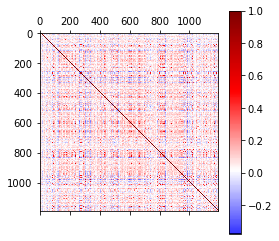

In [22]:
plt.figure();
#corrs[np.diag_indices(corrs.shape[0])]=0
plt.matshow(corrs, cmap = s_cmap);
plt.colorbar();
# plt.savefig('corr.png', dpi = 250)

In [23]:
# optional sparsification
t_corrs = np.triu(corrs)
corr_flat = t_corrs[t_corrs!=0]
corr_flat = corr_flat[abs(corr_flat)>0.05]

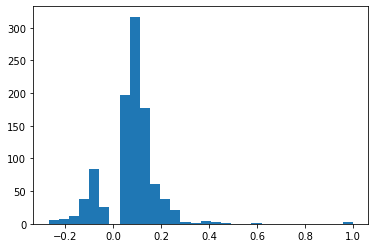

In [24]:
plt.figure();
plt.hist(corr_flat[0:1000], 30);

## Clustering given by sector assignment

In [25]:
hists = np.zeros(len(all_sectors))

for c in sectors_:
     hists[all_sectors.index(c[3])]+=1
        

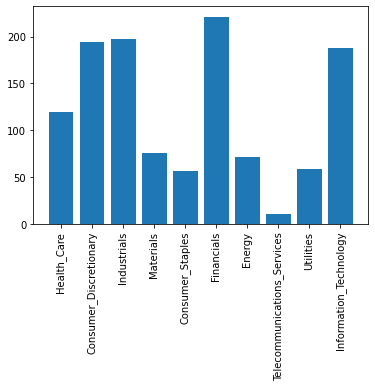

In [26]:
plt.figure();
plt.bar(np.arange(len(all_sectors)), hists);
plt.xticks(np.arange(10), all_sectors, rotation='vertical');
# plt.savefig('hist_sectors.pdf', bbox_inches='tight', pad_inches = 0.25);


In [27]:

prices_sorted = np.zeros(prices_.shape[1])

for i in np.arange(10):
    
    idx_i = [j for j, (a, b, c, d) in enumerate(sectors_) if d == all_sectors[i]]
    
    prices_sorted = np.vstack((prices_sorted, prices_[idx_i]))
    
prices_sorted = prices_sorted[1:]


In [30]:
log_prices_s = np.log(prices_sorted)
returns_s = np.diff(log_prices_s)
ex_rets_s = returns_s - returns[0]
corr_sorted = np.corrcoef(ex_rets_s )

In [31]:
centers = np.hstack(([0],np.cumsum(hists)[:-1])) + hists/2

([<matplotlib.axis.YTick at 0x7f185c055f98>,
 [Text(0, 59.5, 'Health_Care'),
  Text(0, 216.0, 'Consumer_Discretionary'),
  Text(0, 411.5, 'Industrials'),
  Text(0, 548.0, 'Materials'),
  Text(0, 614.5, 'Consumer_Staples'),
  Text(0, 753.5, 'Financials'),
  Text(0, 899.5, 'Energy'),
  Text(0, 940.5, 'Telecommunications_Services'),
  Text(0, 975.5, 'Utilities'),
  Text(0, 1099.0, 'Information_Technology')])

<Figure size 432x288 with 0 Axes>

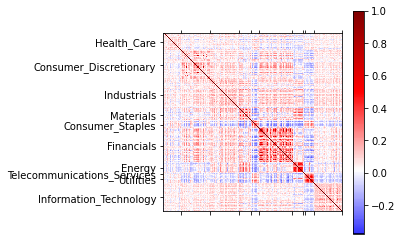

In [32]:
plt.figure();
plt.matshow(corr_sorted, cmap = s_cmap);
plt.colorbar();
plt.xticks(np.cumsum(hists), []*hists.shape[0])
plt.yticks(centers , all_sectors )
# plt.savefig('corr_sectors.png', dpi = 400, bbox_inches='tight', pad_inches = 0.25);

## Save adjacency matrix

In [40]:
A_p = (abs(corrs) + corrs)/2
A_n = abs(corrs - A_p)

In [41]:
A_p = ss.csc_matrix(A_p)
A_n = ss.csc_matrix(A_n)
# ss.save_npz('adjacency_plus_cc.npz', A_p)
# ss.save_npz('adjacency_minus_cc.npz', A_n)